In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [228]:
merged_df = pd.read_csv("conventionaldf.csv")

In [229]:
writer = pd.ExcelWriter('query_output.xlsx', engine='xlsxwriter')

In [230]:
row_counter = 0

Functions

In [232]:
def format_countdf(df):
    perc_df = df.div(df.sum(axis=1), axis=0)#*100
    
    grade_arr = ['A','B','C','D','F','W']
    perc_df.fillna(0,inplace=True)
    
    grade_set = set(grade_arr)
    diff = list(grade_set - set(perc_df.columns.values))
    for letter in diff:
        perc_df[letter] = 0
    perc_df = perc_df[grade_arr]
    
    perc_df = perc_df.style.format("{:.1%}")
    
    return perc_df

In [233]:
def gradebygroup(df, group,row_counter):
    grade_count = df.groupby([group,'grade_con'])['student_cid'].count()
    gm_df = grade_count.unstack(level=-1)
    #pd.set_option('precision', 1)
    df = format_countdf(gm_df)
    df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
    row_counter = row_counter + len(df.index) + 5
    return row_counter

In [234]:
def compare_grades(df, course_list,row_counter):
    #List of students in listed courses
    student_set = set(df.student_cid.values)
    len_array = []
    for course in course_list:
        course_set = set(df[df.course_subject_number==course]['student_cid'].values)
        
        student_set = student_set.intersection(course_set)
        len_array.append(len(list(course_set)))
    
    student_list = list(student_set)
    len_array.append(len(student_list))
    course_list.append("Table Student Count")
    d = {'course':course_list, 'count':len_array}
    #count_df = pd.DataFrame(data=d)
    count_df = pd.DataFrame(data={'count':len_array}, index=course_list)
    count_df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
    row_counter = row_counter + len(count_df.index) + 2
    
    #subset df to only those students
    st_df = df[df.student_cid.isin(student_list)]
    #subset st_df to only those courses
    course_df = st_df[st_df.course_subject_number.isin(course_list)]
    #select only the first attempts at a class
    dupe_mask = course_df.duplicated(subset=['student_cid','course_subject_number'],keep='first')
    coursef_df = course_df[~dupe_mask]
    
    grade_count = coursef_df.groupby(['course_subject_number','grade_con'])['student_cid'].count()
    gm_df = grade_count.unstack(level=-1)
    
    df = format_countdf(gm_df)
    df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
    row_counter = row_counter + len(df.index) + 5
    return row_counter

In [235]:
def compare_or_grades(df, courseA, course_list,row_counter):
    #List of students in listed courses
    courseA_set = set(df[df.course_subject_number==courseA]['student_cid'].values)
    courseB_set = set(df[df.course_subject_number.isin(course_list)]['student_cid'].values)
    student_set = courseA_set.intersection(courseB_set)
    len_array = []
    #new course list
    new_list = [courseA]+course_list
    for course in new_list:
        len_array.append(df[df.course_subject_number==course]['student_cid'].nunique())
    
    student_list = list(student_set)
    len_array.append(len(student_list))
    new_list.append("Table Student Count")
    d = {'course':new_list, 'count':len_array}
    #count_df = pd.DataFrame(data=d)
    count_df = pd.DataFrame(data={'count':len_array}, index=new_list)
    count_df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
    row_counter = row_counter + len(count_df.index) + 2
    
    #subset df to only those students
    st_df = df[df.student_cid.isin(student_list)]
    #subset st_df to only those courses
    course_df = st_df[st_df.course_subject_number.isin(new_list)]
    #select only the first attempts at a class
    dupe_mask = course_df.duplicated(subset=['student_cid','course_subject_number'],keep='first')
    coursef_df = course_df[~dupe_mask]
    
    grade_count = coursef_df.groupby(['course_subject_number','grade_con'])['student_cid'].count()
    gm_df = grade_count.unstack(level=-1)
    
    df = format_countdf(gm_df)
    df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
    row_counter = row_counter + len(df.index) + 5
    return row_counter

In [236]:
def scorebygroup(df, group,row_counter):
    score_count = df.groupby([group,'composite'])['student_cid'].count()
    sc_df = score_count.unstack(level=-1)
    perc_df = sc_df.div(sc_df.sum(axis=1), axis=0)
    perc_df.fillna(0,inplace=True)
    perc_df = perc_df[['<3','3','>3']]
    
    perc_df = perc_df.style.format("{:.1%}")

    perc_df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
    row_counter = row_counter + len(perc_df.index) + 5
    return row_counter

MAT111 and placement test scores

In [237]:
#Select students who take MAT111 – get unique count
mat111_list = merged_df[merged_df.course_subject_number == 'MAT111']['student_cid'].values
take111_df = merged_df[merged_df.student_cid.isin(mat111_list)]
print('Count of unique student IDs in MAT111:',take111_df.student_cid.nunique())

havescores_df = take111_df[merged_df.composite.notna()]
print('Count of unique student IDs in MAT111 with placement scores:',havescores_df.student_cid.nunique())

#Select students with composite score less than 3 – get unique count
scorelow_df = take111_df[merged_df.composite == '<3']
print('Count of unique student IDs in MAT111 with score < 3:',scorelow_df.student_cid.nunique())

#Remove repeated classes by selecting only the first
dupe_mask = havescores_df.duplicated(subset=['student_cid','course_subject_number'],keep='first')
scorelowfirst_df = havescores_df[~dupe_mask]

Count of unique student IDs in MAT111: 4468
Count of unique student IDs in MAT111 with placement scores: 4185
Count of unique student IDs in MAT111 with score < 3: 862


In [238]:
index_array = ['In MAT111','with placement score','with score <3']
count_dict = {'count':[take111_df.student_cid.nunique(),havescores_df.student_cid.nunique(),scorelow_df.student_cid.nunique()]}
pd.DataFrame(data=count_dict, index=index_array).to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
row_counter += 9

In [239]:
#Group in single dataframe
#List of students who take MAT105
mat105_list = scorelowfirst_df[scorelowfirst_df.course_subject_number == 'MAT105']['student_cid'].values
group105_df = scorelowfirst_df.copy()
group105_df['take105'] = group105_df.student_cid.isin(mat105_list)

readiness_list = havescores_df[havescores_df.readiness].student_cid.values
#Restrict to MAT111
grade111_df = group105_df[group105_df.course_subject_number=='MAT111']
print('Count of unique student IDs who take MAT105:',grade111_df[grade111_df.take105].student_cid.nunique())
print('Count of unique student IDs who take MAT105 Readiness Program:',havescores_df[havescores_df.readiness].student_cid.nunique())
print('Count of unique student IDs who are in both:', len((set(readiness_list)).intersection(set(mat105_list))))

Count of unique student IDs who take MAT105: 199
Count of unique student IDs who take MAT105 Readiness Program: 357
Count of unique student IDs who are in both: 4


In [240]:
take111_df['take105'] = 'None'
take111_df.loc[take111_df.student_cid.isin(readiness_list),'take105'] = 'MAT105 Readiness Program'
take111_df.loc[take111_df.student_cid.isin(mat105_list),'take105'] = 'MAT105 Class'

In [241]:
row_counter = gradebygroup(merged_df, 'take105',row_counter)
#perc_df = gradebygroup(merged_df, 'take105')  
#display(perc_df)
#perc_df.to_excel(writer, sheet_name='Sheet1', startrow = 0)
print('Count of unique student IDs who take MAT105:',grade111_df[grade111_df.take105].student_cid.nunique())
print('Count of unique student IDs who take MAT105 Readiness Program:',havescores_df[havescores_df.readiness].student_cid.nunique())
print('Count of unique student IDs who are in both:', len((set(readiness_list)).intersection(set(mat105_list))))

Count of unique student IDs who take MAT105: 199
Count of unique student IDs who take MAT105 Readiness Program: 357
Count of unique student IDs who are in both: 4


In [242]:
index_array = ['Take MAT105','Take MAT105 Readiness Program','Take Both']
count_dict = {'count':[grade111_df[grade111_df.take105].student_cid.nunique(),
                       havescores_df[havescores_df.readiness].student_cid.nunique(),
                       len((set(readiness_list)).intersection(set(mat105_list)))]}
pd.DataFrame(data=count_dict, index=index_array).to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
row_counter += 9

Previous numbers were from data that included duplicates

In [243]:
#diff = set(['A','B','C','D','F','W']) - set(perc_df.columns.values)
#list(diff)

Compare students who take MAT111 as a prereq to Calc vs MAT111 as a terminal course

In [244]:
#What % of MAT 111 students take 151
#Select students who take MAT111 – get unique count
mat111_list = merged_df[merged_df.course_subject_number == 'MAT111']['student_cid'].values
take111_df = merged_df[merged_df.student_cid.isin(mat111_list)]
print('Count of unique student IDs in MAT111:',take111_df.student_cid.nunique())
#How many take MAT151
mat151_list = take111_df[take111_df.course_subject_number == 'MAT151']['student_cid'].values
take151_df = take111_df[take111_df.student_cid.isin(mat151_list)]
print('Count of unique student IDs in MAT111 and MAT151:',take151_df.student_cid.nunique())

Count of unique student IDs in MAT111: 4468
Count of unique student IDs in MAT111 and MAT151: 1069


In [245]:
row_counter = compare_or_grades(merged_df, 'MAT111',['MAT141','MAT142'],row_counter)
#df_14x = compare_or_grades(merged_df, 'MAT111',['MAT141','MAT142'])
#display(df_14x)
#df_14x.to_excel(writer, sheet_name='Sheet1', startrow = 10)


In [246]:
row_counter = compare_or_grades(merged_df, 'MAT111',['STT210','STT215'],row_counter)
#df_21x = compare_or_grades(merged_df, 'MAT111',['STT210','STT215'])
#display(df_21x)
#df_21x.to_excel(writer, sheet_name='Sheet1', startrow = 20)


In [247]:
row_counter = compare_grades(merged_df, ['MAT111','MAT112','MAT161'],row_counter)
#df_161 = compare_grades(merged_df, ['MAT111','MAT112','MAT161'])
#df_161.to_excel(writer, sheet_name='Sheet1', startrow = 30)
#display(df_161)

In [248]:
row_counter = compare_grades(merged_df, ['MAT111','MAT151','MAT161'], row_counter)
# df_151_161 = compare_grades(merged_df, ['MAT111','MAT151','MAT161'])
# df_151_161.to_excel(writer, sheet_name='Sheet1', startrow = 40)

# display(df_151_161)

In [249]:
row_counter = compare_grades(merged_df, ['MAT111','MAT151'], row_counter)
# df_151 = compare_grades(merged_df, ['MAT111','MAT151'])
# df_151.to_excel(writer, sheet_name='Sheet1', startrow = 50)

# display(df_151)

In [250]:
row_counter = compare_grades(merged_df, ['MAT111'], row_counter)
# df_111 = compare_grades(merged_df, ['MAT111'])
# df_111.to_excel(writer, sheet_name='Sheet1', startrow = 60)

# display(df_111)

Metamajor breakdown for MAT111 and placement scores

In [251]:
#select MAT 111
mat111f_clust = merged_df[merged_df.course_subject_number == 'MAT111']

In [252]:
mat111pl_df = mat111f_clust[mat111f_clust.composite.notna()]

In [253]:
clust_count = mat111f_clust.meta_major.value_counts()
clust_count

CHHS                 995
STEM                 879
Business             785
Undecided/Unknown    683
Social Sciences      656
Arts/Humanities      347
Education            123
Name: meta_major, dtype: int64

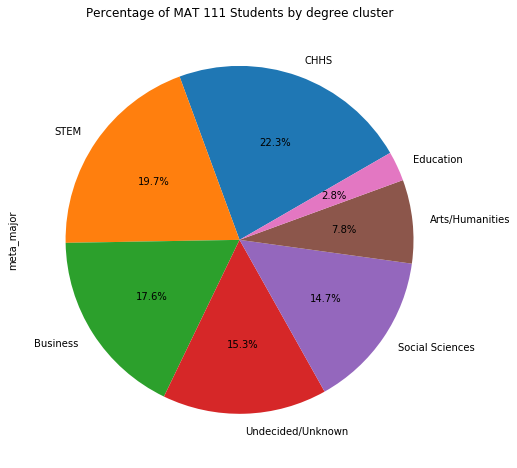

In [254]:
clust_count.plot(kind='pie', title='Percentage of MAT 111 Students by degree cluster', figsize=[8,8],
          autopct='%1.1f%%',startangle=30)

In [255]:
row_counter = gradebygroup(mat111f_clust, 'meta_major', row_counter)
# clust_grade = gradebygroup(mat111f_clust, 'meta_major')
# clust_grade.to_excel(writer, sheet_name='Sheet1', startrow = 70)

# display(clust_grade)

In [256]:
row_counter = scorebygroup(mat111pl_df, 'meta_major', row_counter)
# clust_score = scorebygroup(mat111pl_df, 'meta_major')
# clust_score.to_excel(writer, sheet_name='Sheet1', startrow = 80)

# display(clust_score)

In [257]:
#number of students without placement scores for each major
mat111f_clust[mat111f_clust.composite.isnull()].groupby('meta_major')['meta_major'].count()

meta_major
Arts/Humanities      36
Business             44
CHHS                 72
Education             8
STEM                 49
Social Sciences      45
Undecided/Unknown    29
Name: meta_major, dtype: int64

In [258]:
#number of students with placement scores for each major
mat111pl_df.groupby('meta_major')['meta_major'].count()

meta_major
Arts/Humanities      311
Business             741
CHHS                 923
Education            115
STEM                 830
Social Sciences      611
Undecided/Unknown    654
Name: meta_major, dtype: int64

Compare MAT111 grades for those that go on to 151, 161, or other

In [259]:
#mat 151 list
only151_list = list(set(merged_df[merged_df.Calculus=='MAT151'].student_cid.values))
#mat 161 list
mat161_list = list(set(merged_df[merged_df.Calculus=='MAT161'].student_cid.values))
#no calc list
nocalc_list = list(set(merged_df[merged_df.Calculus=='No Calculus'].student_cid.values))

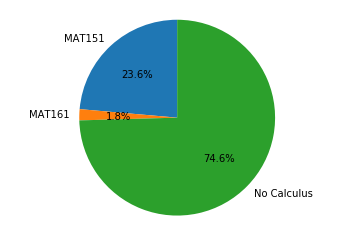

In [260]:
cat_len = np.array([len(only151_list),len(mat161_list),len(nocalc_list)])
labels = ['MAT151','MAT161','No Calculus']
fig1, ax1 = plt.subplots()
ax1.pie(cat_len, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [261]:
grade_count = mat111f_clust.groupby(['Calculus','grade'])['student_cid'].count()
gm_df = grade_count.unstack(level=-1)
pd.set_option('precision', 1)
perc_df = gm_df.div(gm_df.sum(axis=1), axis=0)*100


In [262]:
row_counter = gradebygroup(mat111f_clust, 'Calculus',row_counter)
# perc_df = gradebygroup(mat111f_clust, 'Calculus')  
# perc_df.to_excel(writer, sheet_name='Sheet1', startrow = 90)

# perc_df

In [263]:
row_counter = scorebygroup(mat111f_clust, 'Calculus', row_counter)
# clust_score = scorebygroup(mat111f_clust, 'Calculus')
# clust_score.to_excel(writer, sheet_name='Sheet1', startrow = 100)

# display(clust_score)

Number of Repeats of MAT111

In [264]:
#Number of repeats of MAT 111
dup_df = pd.read_csv("duplicatesdf.csv")
all_mat111 = dup_df[dup_df.course_subject_number == 'MAT111']
all_mat111.student_cid.value_counts().value_counts()

1    4154
2     291
3      23
Name: student_cid, dtype: int64

In [265]:
all_mat111.student_cid.nunique()

4468

In [266]:
id802 = np.load('repID802.npy')

In [267]:
repeat_ids = all_mat111.student_cid.value_counts()

In [268]:
repid_array = repeat_ids[repeat_ids == 2].index.values

In [269]:
repid3_array = repeat_ids[repeat_ids == 3].index.values

In [270]:
id_diff = list(set(id802) - set(repid_array))

In [271]:
#all_mat111[all_mat111.student_cid.isin(repid3_array)].sort_values(by='student_cid')

In [272]:
#merged_df.info()

In [273]:
#MAT111 repeats by category
#MAT151 students
all_111_151 = all_mat111[all_mat111.student_cid.isin(only151_list)]
rep_151 = all_111_151.student_cid.value_counts().value_counts()
#MAT161 students
all_111_161 = all_mat111[all_mat111.student_cid.isin(mat161_list)]
rep_161 = all_111_161.student_cid.value_counts().value_counts()
#No Calculus students
#MAT151 students
all_111_no = all_mat111[all_mat111.student_cid.isin(nocalc_list)]
rep_nocalc = all_111_no.student_cid.value_counts().value_counts()


In [274]:
print('MAT151\n',rep_151,'\n')
print('MAT161\n',rep_161,'\n')
print('No Calculus\n',rep_nocalc)

MAT151
 1    1005
2      48
3       2
Name: student_cid, dtype: int64 

MAT161
 1    78
2     4
Name: student_cid, dtype: int64 

No Calculus
 1    3071
2     239
3      21
Name: student_cid, dtype: int64


In [275]:
merged_df[merged_df.course_number == 152]

,Unnamed: 0,Unnamed: 0_x,snapshot_term_code,snapshot_name,exclude_from_ipeds_cai_flag,crn_id,student_cid,repeat_indicator,course_subject_code,course_number,...,studentID,testdate,readiness,composite,major,meta_major,Calculus,grade_con,term_order,take105
843,812,812,20181,Spring 2018 Post-Grades,N,20116.0,850398954,NaN,MAT,152.0,...,8.5e+08,1.4e+18,False,3,Geology,STEM,MAT151,C,20181,None
2584,2424,2424,20171,Spring 2017 Post-Grades,N,20116.0,850409472,NaN,MAT,152.0,...,8.5e+08,1.4e+18,False,>3,Isaac Bear Early College,Undecided/Unknown,MAT161,A,20171,None
4796,4560,4560,20181,Spring 2018 Post-Grades,N,20116.0,850427411,NaN,MAT,152.0,...,NaN,NaN,NaN,NaN,Oceanography,STEM,MAT151,A,20181,None


In [276]:
merged_df.course_subject_number.value_counts()

MAT111     4468
MAT151     1069
BAN 280     504
STT215      439
MAT112      251
MAT105      200
PSY 225     198
STT210       87
MAT161       79
MAT141       53
MAT162       49
MAT101       36
MAT142       19
PBH 299      14
MAT261        9
STT305        6
MAT335        6
MAT115        4
MAT245        3
MAT152        3
MAT275        2
STT315        2
MAT296        2
STT350        2
MAT361        1
STT412        1
MAT336        1
MAT321        1
STT425        1
Name: course_subject_number, dtype: int64

In [277]:
mat111f_clust.major.value_counts().head(10).to_excel(writer, sheet_name='Sheet1', startrow = row_counter)
row_counter += 15

In [278]:
new_count_df = pd.read_csv('nonmathcount.csv', header=None, names=['Course','Count'],index_col=0)
new_count_df.to_excel(writer, sheet_name='Sheet1', startrow = row_counter)

In [279]:
writer.save()